In [1]:
import keras
from keras.models import Sequential, Model, load_model

from keras.layers import Dense, Dropout, Activation, Flatten, Input, Lambda
from keras.layers import Conv2D, MaxPooling2D, Conv1D, MaxPooling1D, LSTM, ConvLSTM2D, GRU, BatchNormalization, LocallyConnected2D, Permute
from keras.layers import Concatenate, Reshape, Softmax, Conv2DTranspose, Embedding, Multiply
from keras.callbacks import ModelCheckpoint, EarlyStopping, Callback
from keras import regularizers
from keras import backend as K
import keras.losses

import tensorflow as tf
from tensorflow.python.framework import ops

import isolearn.keras as iso

import numpy as np

import tensorflow as tf
import logging
logging.getLogger('tensorflow').setLevel(logging.ERROR)

import pandas as pd

import os
import pickle
import numpy as np

import scipy.sparse as sp
import scipy.io as spio

import matplotlib.pyplot as plt

import isolearn.io as isoio
import isolearn.keras as isol

from genesis.visualization import *
from genesis.generator import *
from genesis.predictor import *
from genesis.optimizer import *

from definitions.generator.aparent_gan_seed_generator_linear import get_load_generator_network_func
from definitions.predictor.aparent import load_saved_predictor

import sklearn
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from scipy.stats import pearsonr

import seaborn as sns

from matplotlib import colors

def initialize_sequence_templates(generator, sequence_templates) :

    embedding_templates = []
    embedding_masks = []

    for k in range(len(sequence_templates)) :
        sequence_template = sequence_templates[k]
        onehot_template = isol.OneHotEncoder(seq_length=len(sequence_template))(sequence_template).reshape((1, len(sequence_template), 4))

        for j in range(len(sequence_template)) :
            if sequence_template[j] not in ['N', 'X'] :
                nt_ix = np.argmax(onehot_template[0, j, :])
                onehot_template[:, j, :] = -4.0
                onehot_template[:, j, nt_ix] = 10.0
            elif sequence_template[j] == 'X' :
                onehot_template[:, j, :] = -1.0

        onehot_mask = np.zeros((1, len(sequence_template), 4))
        for j in range(len(sequence_template)) :
            if sequence_template[j] == 'N' :
                onehot_mask[:, j, :] = 1.0

        embedding_templates.append(onehot_template.reshape(1, -1))
        embedding_masks.append(onehot_mask.reshape(1, -1))

    embedding_templates = np.concatenate(embedding_templates, axis=0)
    embedding_masks = np.concatenate(embedding_masks, axis=0)

    generator.get_layer('template_dense').set_weights([embedding_templates])
    generator.get_layer('template_dense').trainable = False

    generator.get_layer('mask_dense').set_weights([embedding_masks])
    generator.get_layer('mask_dense').trainable = False


Using TensorFlow backend.


In [2]:
from keras.layers import Layer, InputSpec
from keras import initializers, regularizers, constraints

class InstanceNormalization(Layer):
    """Instance normalization layer.
    Normalize the activations of the previous layer at each step,
    i.e. applies a transformation that maintains the mean activation
    close to 0 and the activation standard deviation close to 1.
    # Arguments
        axis: Integer, the axis that should be normalized
            (typically the features axis).
            For instance, after a `Conv2D` layer with
            `data_format="channels_first"`,
            set `axis=1` in `InstanceNormalization`.
            Setting `axis=None` will normalize all values in each
            instance of the batch.
            Axis 0 is the batch dimension. `axis` cannot be set to 0 to avoid errors.
        epsilon: Small float added to variance to avoid dividing by zero.
        center: If True, add offset of `beta` to normalized tensor.
            If False, `beta` is ignored.
        scale: If True, multiply by `gamma`.
            If False, `gamma` is not used.
            When the next layer is linear (also e.g. `nn.relu`),
            this can be disabled since the scaling
            will be done by the next layer.
        beta_initializer: Initializer for the beta weight.
        gamma_initializer: Initializer for the gamma weight.
        beta_regularizer: Optional regularizer for the beta weight.
        gamma_regularizer: Optional regularizer for the gamma weight.
        beta_constraint: Optional constraint for the beta weight.
        gamma_constraint: Optional constraint for the gamma weight.
    # Input shape
        Arbitrary. Use the keyword argument `input_shape`
        (tuple of integers, does not include the samples axis)
        when using this layer as the first layer in a Sequential model.
    # Output shape
        Same shape as input.
    # References
        - [Layer Normalization](https://arxiv.org/abs/1607.06450)
        - [Instance Normalization: The Missing Ingredient for Fast Stylization](
        https://arxiv.org/abs/1607.08022)
    """
    def __init__(self,
                 axis=None,
                 epsilon=1e-3,
                 center=True,
                 scale=True,
                 beta_initializer='zeros',
                 gamma_initializer='ones',
                 beta_regularizer=None,
                 gamma_regularizer=None,
                 beta_constraint=None,
                 gamma_constraint=None,
                 **kwargs):
        super(InstanceNormalization, self).__init__(**kwargs)
        self.supports_masking = True
        self.axis = axis
        self.epsilon = epsilon
        self.center = center
        self.scale = scale
        self.beta_initializer = initializers.get(beta_initializer)
        self.gamma_initializer = initializers.get(gamma_initializer)
        self.beta_regularizer = regularizers.get(beta_regularizer)
        self.gamma_regularizer = regularizers.get(gamma_regularizer)
        self.beta_constraint = constraints.get(beta_constraint)
        self.gamma_constraint = constraints.get(gamma_constraint)

    def build(self, input_shape):
        ndim = len(input_shape)
        if self.axis == 0:
            raise ValueError('Axis cannot be zero')

        if (self.axis is not None) and (ndim == 2):
            raise ValueError('Cannot specify axis for rank 1 tensor')

        self.input_spec = InputSpec(ndim=ndim)

        if self.axis is None:
            shape = (1,)
        else:
            shape = (input_shape[self.axis],)

        if self.scale:
            self.gamma = self.add_weight(shape=shape,
                                         name='gamma',
                                         initializer=self.gamma_initializer,
                                         regularizer=self.gamma_regularizer,
                                         constraint=self.gamma_constraint)
        else:
            self.gamma = None
        if self.center:
            self.beta = self.add_weight(shape=shape,
                                        name='beta',
                                        initializer=self.beta_initializer,
                                        regularizer=self.beta_regularizer,
                                        constraint=self.beta_constraint)
        else:
            self.beta = None
        self.built = True

    def call(self, inputs, training=None):
        input_shape = K.int_shape(inputs)
        reduction_axes = list(range(0, len(input_shape)))

        if self.axis is not None:
            del reduction_axes[self.axis]

        del reduction_axes[0]

        mean = K.mean(inputs, reduction_axes, keepdims=True)
        stddev = K.std(inputs, reduction_axes, keepdims=True) + self.epsilon
        normed = (inputs - mean) / stddev

        broadcast_shape = [1] * len(input_shape)
        if self.axis is not None:
            broadcast_shape[self.axis] = input_shape[self.axis]

        if self.scale:
            broadcast_gamma = K.reshape(self.gamma, broadcast_shape)
            normed = normed * broadcast_gamma
        if self.center:
            broadcast_beta = K.reshape(self.beta, broadcast_shape)
            normed = normed + broadcast_beta
        return normed

    def get_config(self):
        config = {
            'axis': self.axis,
            'epsilon': self.epsilon,
            'center': self.center,
            'scale': self.scale,
            'beta_initializer': initializers.serialize(self.beta_initializer),
            'gamma_initializer': initializers.serialize(self.gamma_initializer),
            'beta_regularizer': regularizers.serialize(self.beta_regularizer),
            'gamma_regularizer': regularizers.serialize(self.gamma_regularizer),
            'beta_constraint': constraints.serialize(self.beta_constraint),
            'gamma_constraint': constraints.serialize(self.gamma_constraint)
        }
        base_config = super(InstanceNormalization, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

def make_gen_resblock(n_channels=64, window_size=8, dilation_rate=1, group_ix=0, layer_ix=0) :

    #Initialize res block layers
    batch_norm_0 = InstanceNormalization(axis=-1, name='gan_generator_resblock_' + str(group_ix) + '_' + str(layer_ix) + '_batch_norm_0')

    relu_0 = Lambda(lambda x: K.relu(x))

    conv_0 = Conv2D(n_channels, (1, window_size), dilation_rate=dilation_rate, strides=(1, 1), padding='same', activation='linear', kernel_initializer='glorot_normal', name='gan_generator_resblock_' + str(group_ix) + '_' + str(layer_ix) + '_conv_0')

    batch_norm_1 = InstanceNormalization(axis=-1, name='gan_generator_resblock_' + str(group_ix) + '_' + str(layer_ix) + '_batch_norm_1')

    relu_1 = Lambda(lambda x: K.relu(x))

    conv_1 = Conv2D(n_channels, (1, window_size), dilation_rate=dilation_rate, strides=(1, 1), padding='same', activation='linear', kernel_initializer='glorot_normal', name='gan_generator_resblock_' + str(group_ix) + '_' + str(layer_ix) + '_conv_1')

    skip_1 = Lambda(lambda x: x[0] + x[1], name='gan_generator_resblock_' + str(group_ix) + '_' + str(layer_ix) + '_skip_1')

    #Execute res block
    def _resblock_func(input_tensor, training=True) :
        batch_norm_0_out = batch_norm_0(input_tensor, training=training)
        relu_0_out = relu_0(batch_norm_0_out)
        conv_0_out = conv_0(relu_0_out)

        batch_norm_1_out = batch_norm_1(conv_0_out, training=training)
        relu_1_out = relu_1(batch_norm_1_out)
        conv_1_out = conv_1(relu_1_out)

        skip_1_out = skip_1([conv_1_out, input_tensor])
        
        return skip_1_out

    return _resblock_func


#GAN Generator Model definition
def load_generator_network_4_resblocks(batch_size, seq_length=205) :

    #Generator network parameters
    latent_size = 100
    n_resblocks = 4
    n_channels = 32

    #Policy network definition
    policy_dense_0 = Dense(21 * 384, activation='linear', kernel_initializer='glorot_uniform', name='gan_generator_dense_0')

    policy_dense_0_reshape = Reshape((1, 21, 384))

    policy_deconv_0 = Conv2DTranspose(256, (1, 7), strides=(1, 2), padding='valid', activation='linear', kernel_initializer='glorot_normal', name='gan_generator_deconv_0')

    policy_deconv_1 = Conv2DTranspose(192, (1, 8), strides=(1, 2), padding='valid', activation='linear', kernel_initializer='glorot_normal', name='gan_generator_deconv_1')

    policy_deconv_2 = Conv2DTranspose(128, (1, 7), strides=(1, 2), padding='valid', activation='linear', kernel_initializer='glorot_normal', name='gan_generator_deconv_2')

    policy_conv_3 = Conv2D(n_channels, (1, 1), strides=(1, 1), padding='same', activation='linear', kernel_initializer='glorot_normal', name='gan_generator_conv_3')

    batch_norm_dense_0 = InstanceNormalization(axis=-1, name='gan_generator_batch_norm_dense_0')
    relu_dense_0 = Lambda(lambda x: K.relu(x))

    batch_norm_0 = InstanceNormalization(axis=-1, name='gan_generator_batch_norm_0')
    relu_0 = Lambda(lambda x: K.relu(x))
    batch_norm_1 = InstanceNormalization(axis=-1, name='gan_generator_batch_norm_1')
    relu_1 = Lambda(lambda x: K.relu(x))
    batch_norm_2 = InstanceNormalization(axis=-1, name='gan_generator_batch_norm_2')
    relu_2 = Lambda(lambda x: K.relu(x))
    
    skip_conv_0 = Conv2D(n_channels, (1, 1), strides=(1, 1), padding='same', activation='linear', kernel_initializer='glorot_normal', name='gan_generator_skip_conv_0')
    
    resblocks = []
    for layer_ix in range(n_resblocks) :
        resblocks.append(make_gen_resblock(n_channels=n_channels, window_size=8, dilation_rate=1, group_ix=0, layer_ix=layer_ix))
    
    last_block_conv = Conv2D(n_channels, (1, 1), strides=(1, 1), padding='same', activation='linear', kernel_initializer='glorot_normal', name='gan_generator_last_block_conv')
    
    skip_add = Lambda(lambda x: x[0] + x[1], name='gan_generator_skip_add')
    
    final_conv = Conv2D(4, (1, 1), strides=(1, 1), padding='same', activation='linear', kernel_initializer='glorot_normal', name='gan_generator_final_conv')
    final_reshape = Lambda(lambda x: K.permute_dimensions(x, (0, 2, 3, 1)))
    
    def _generator_func(seed_input) :
        relu_dense_0_out = relu_dense_0(batch_norm_dense_0(policy_dense_0_reshape(policy_dense_0(seed_input)), training=True))
        
        policy_relu_0_out = relu_0(batch_norm_0(policy_deconv_0(relu_dense_0_out), training=True))
        policy_relu_1_out = relu_1(batch_norm_1(policy_deconv_1(policy_relu_0_out), training=True))
        policy_relu_2_out = relu_2(batch_norm_2(policy_deconv_2(policy_relu_1_out), training=True))

        policy_conv_3_out = policy_conv_3(policy_relu_2_out)

        #Connect group of res blocks
        output_tensor = policy_conv_3_out

        #Res block group 0
        skip_conv_0_out = skip_conv_0(output_tensor)

        for layer_ix in range(n_resblocks) :
            output_tensor = resblocks[layer_ix](output_tensor, training=True)

        #Last res block extr conv
        last_block_conv_out = last_block_conv(output_tensor)

        skip_add_out = skip_add([last_block_conv_out, skip_conv_0_out])

        #Final conv out
        final_conv_out = final_conv(skip_add_out)
        
        return final_reshape(final_conv_out)

    def _post_compile_func(generator_model, gan_path) :
        
        saved_model = load_model(gan_path, custom_objects={'st_sampled_softmax': st_sampled_softmax, 'st_hardmax_softmax': st_hardmax_softmax, '<lambda>': lambda y_true, y_pred: y_pred, 'InstanceNormalization': InstanceNormalization})
        
        #generator_model.load_weights(gan_path)
        
        for layer in generator_model.layers :
            if "gan_generator" in layer.name :
                if len(layer.get_weights()) > 0 :
                    layer.set_weights(saved_model.get_layer('policy_generator' + layer.name[13:]).get_weights())
                layer.trainable = False

    return _generator_func, _post_compile_func


In [7]:

def get_seed_gauss_prior() : 

    def seed_gauss_prior(seed) :
        
        mse = K.mean(seed**2, axis=-1)
        
        return mse

    return seed_gauss_prior

#Define target isoform loss function
def get_isoform_loss(target_isos, isoform_start=80, isoform_end=115, use_start=0, use_end=70, cse_start=70, cse_end=76, dse_start=76, dse_end=125, similarity_weight=0.0, similarity_margin=0.5, punish_dn_cse=0.0, punish_up_c=0.0, punish_dn_c=0.0, punish_up_g=0.0, punish_dn_g=0.0, punish_up_aa=0.0, punish_dn_aa=0.0, gauss_prior_weight=0.0) :
    
    target_iso = np.zeros((len(target_isos), 1))
    for i, t_iso in enumerate(target_isos) :
        target_iso[i, 0] = t_iso
    
    punish_dn_cse_func = get_punish_cse(pwm_start=74, pwm_end=dse_end)
    
    punish_up_c_func = get_punish_c(pwm_start=use_start, pwm_end=use_end)
    punish_dn_c_func = get_punish_c(pwm_start=dse_start, pwm_end=dse_end)
    
    punish_up_g_func = get_punish_g(pwm_start=use_start, pwm_end=use_end)
    punish_dn_g_func = get_punish_g(pwm_start=use_start, pwm_end=use_end)
    
    punish_up_aa_func = get_punish_aa(pwm_start=use_start, pwm_end=use_end)
    punish_dn_aa_func = get_punish_aa(pwm_start=dse_start, pwm_end=dse_end)
    
    pwm_sample_entropy_func = get_pwm_margin_sample_entropy_masked(pwm_start=20, pwm_end=200, margin=similarity_margin, shift_1_nt=True)
    
    extra_sim = np.ones((len(target_isos), 1, 205, 4, 1))
    for i in range(len(target_isos)) :
        extra_sim[i, 0, 70-4:76, :, 0] = 0.0
    
    gauss_prior_func = get_seed_gauss_prior()
    
    def loss_func(loss_tensors) :
        _, _, _, sequence_class, pwm_logits_1, pwm_logits_2, pwm_1, pwm_2, sampled_pwm_1, sampled_pwm_2, mask, sampled_mask, seed_1, seed_2, iso_pred, cut_pred, iso_score_pred, cut_score_pred = loss_tensors
        
        #Create target isoform with sample axis
        iso_targets = K.constant(target_iso)
        iso_true = K.gather(iso_targets, sequence_class[:, 0])
        iso_true = K.tile(K.expand_dims(iso_true, axis=-1), (1, K.shape(sampled_pwm_1)[1], 1))

        #Specify costs
        iso_loss = 2.0 * K.mean(symmetric_sigmoid_kl_divergence(iso_true, iso_pred), axis=1)
        
        seq_loss = 0.0
        seq_loss += punish_dn_cse * K.mean(punish_dn_cse_func(sampled_pwm_1), axis=1)
        
        seq_loss += punish_up_c * K.mean(punish_up_c_func(sampled_pwm_1), axis=1)
        seq_loss += punish_dn_c * K.mean(punish_dn_c_func(sampled_pwm_1), axis=1)
        
        seq_loss += punish_up_g * K.mean(punish_up_g_func(sampled_pwm_1), axis=1)
        seq_loss += punish_dn_g * K.mean(punish_dn_g_func(sampled_pwm_1), axis=1)
        
        seq_loss += punish_up_aa * K.mean(punish_up_aa_func(sampled_pwm_1), axis=1)
        seq_loss += punish_dn_aa * K.mean(punish_dn_aa_func(sampled_pwm_1), axis=1)
        
        
        extra_sims = K.constant(extra_sim)
        extra_sim_mask = K.gather(extra_sims, sequence_class[:, 0])
        extra_sim_mask = K.tile(extra_sim_mask, (1, K.shape(sampled_pwm_1)[1], 1, 1, 1))
        
        entropy_loss = similarity_weight * K.mean(pwm_sample_entropy_func(sampled_pwm_1, sampled_pwm_2, sampled_mask * extra_sim_mask), axis=1)
        entropy_loss += gauss_prior_weight * gauss_prior_func(seed_1)
        
        #Compute total loss
        total_loss = iso_loss + seq_loss + entropy_loss

        return total_loss
    
    return loss_func

class EpochVariableCallback(Callback):
    def __init__(self, my_variable, my_func):
        self.my_variable = my_variable       
        self.my_func = my_func
    def on_epoch_end(self, epoch, logs={}):
        K.set_value(self.my_variable, self.my_func(K.get_value(self.my_variable), epoch))

#Function for running GENESIS
def run_genesis(sequence_templates, loss_func, library_contexts, model_path, get_gan_func, gan_path, batch_size=32, n_samples=1, n_epochs=10, steps_per_epoch=100) :
    
    gan_func, post_compile_gan_func = get_gan_func(batch_size, seq_length=len(sequence_templates[0]))
    
    load_generator_network = get_load_generator_network_func(gan_func)
    
    #Build Generator Network
    _, generator = build_generator(batch_size, len(sequence_templates[0]), load_generator_network, n_classes=len(sequence_templates), n_samples=n_samples, sequence_templates=sequence_templates, batch_normalize_pwm=False)
    
    #Post compile generator, load pre-trained GAN weights
    post_compile_gan_func(generator, gan_path)

    #Build Predictor Network and hook it on the generator PWM output tensor
    _, sample_predictor = build_predictor(generator, load_saved_predictor(model_path, library_contexts=library_contexts), batch_size, n_samples=n_samples, eval_mode='sample')

    #Build Loss Model (In: Generator seed, Out: Loss function)
    _, loss_model = build_loss_model(sample_predictor, loss_func)
    
    #Specify Optimizer to use
    opt = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999)

    #Compile Loss Model (Minimize self)
    loss_model.compile(loss=lambda true, pred: pred, optimizer=opt)

    #Fit Loss Model
    train_history = loss_model.fit(
        [], np.ones((1, 1)),
        epochs=n_epochs,
        steps_per_epoch=steps_per_epoch
    )

    return generator, sample_predictor, train_history


In [8]:
#Specfiy file path to pre-trained predictor network

save_dir = os.path.join(os.getcwd(), '../../../../aparent/saved_models')
saved_predictor_model_name = 'aparent_plasmid_iso_cut_distalpas_all_libs_no_sampleweights_sgd.h5'
saved_predictor_model_path = os.path.join(save_dir, saved_predictor_model_name)

#Specify file path to pre-trained GAN generator network

save_dir = os.path.join(os.getcwd(), '../gan/saved_models')
saved_gan_name = 'gan_simple_gen_resnet_4_resblocks_disc_conv_max_pool_hl_wgan_multisample_instancenorm_normal_generator.h5'
saved_gan_path = os.path.join(save_dir, saved_gan_name)


In [9]:
#Maximize isoform proportions for all native minigene libraries

sequence_templates = [
    'TCCCTACACGACGCTCTTCCGATCTNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNAATAAANNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNAATAAANNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNCGCCTAACCCTAAGCAGATTCTTCATGCAATTG'
]

library_contexts = [
    'simple'
]

target_isos = [
    1.0
]

margin_similarities = [
    0.5
]


In [10]:
#Train APA Cleavage GENESIS Network

print("Training GENESIS")

#Number of PWMs to generate per objective
batch_size = 32
#Number of One-hot sequences to sample from the PWM at each grad step
n_samples = 1
#Number of epochs per objective to optimize
n_epochs = 10
#Number of steps (grad updates) per epoch
steps_per_epoch = 500

get_gan_func = load_generator_network_4_resblocks

gan_save_suffix = '_simple_gen_resnet_4_resblocks_disc_conv_max_pool_hl_wgan_multisample_instancenorm_normal_singlesample_descent'

train_history = None

for class_i in range(len(sequence_templates)) :
    print("Target iso = " + str(target_isos[class_i]))
    
    lib_name = library_contexts[class_i].split("_")[0]
    print("Library context = " + str(lib_name))
    
    K.clear_session()
    
    loss = get_isoform_loss(
        [target_isos[class_i]],
        use_start=25,
        use_end=70,
        cse_start=70,
        cse_end=76,
        dse_start=76,
        dse_end=172,
        similarity_weight=5.0,
        similarity_margin=margin_similarities[class_i],
        punish_dn_cse=1.0,
        punish_up_c=0.0015,
        punish_dn_c=0.0001,
        punish_up_g=0.0001,
        punish_dn_g=0.0001,
        punish_up_aa=0.00025,
        punish_dn_aa=0.005,
        gauss_prior_weight=0.5
    )

    genesis_generator, genesis_predictor, train_history = run_genesis([sequence_templates[class_i]], loss, [library_contexts[class_i]], saved_predictor_model_path, get_gan_func, saved_gan_path, batch_size, n_samples, n_epochs, steps_per_epoch)

    genesis_generator.get_layer('lambda_rand_sequence_class').function = lambda inp: inp
    genesis_generator.get_layer('lambda_rand_input_1').function = lambda inp: inp
    genesis_generator.get_layer('lambda_rand_input_2').function = lambda inp: inp

    genesis_predictor.get_layer('lambda_rand_sequence_class').function = lambda inp: inp
    genesis_predictor.get_layer('lambda_rand_input_1').function = lambda inp: inp
    genesis_predictor.get_layer('lambda_rand_input_2').function = lambda inp: inp

    # Save model and weights
    save_dir = 'saved_models'

    if not os.path.isdir(save_dir):
        os.makedirs(save_dir)
    
    model_name = 'genesis_target_isoform_' + str(target_isos[class_i]).replace(".", "") + '_gan' + gan_save_suffix + '_' + str(lib_name) + '_marginsim_' + str(margin_similarities[class_i]).replace(".", "") + '_generator.h5'
    model_path = os.path.join(save_dir, model_name)
    genesis_generator.save(model_path)
    print('Saved trained model at %s ' % model_path)

    model_name = 'genesis_target_isoform_' + str(target_isos[class_i]).replace(".", "") + '_gan' + gan_save_suffix + '_' + str(lib_name) + '_marginsim_' + str(margin_similarities[class_i]).replace(".", "") + '_predictor.h5'
    model_path = os.path.join(save_dir, model_name)
    genesis_predictor.save(model_path)
    print('Saved trained model at %s ' % model_path)


Training GENESIS
Target iso = 1.0
Library context = simple


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Epoch 1/10
500/500 [==============================] - 32s 64ms/step - loss: 2.0183
Epoch 2/10
500/500 [==============================] - 27s 53ms/step - loss: 1.5562
Epoch 3/10
500/500 [==============================] - 26s 53ms/step - loss: 1.4180
Epoch 4/10
500/500 [==============================] - 27s 53ms/step - loss: 1.3479
Epoch 5/10
500/500 [==============================] - 27s 53ms/step - loss: 1.3213
Epoch 6/10
500/500 [==============================] - 26s 53ms/step - loss: 1.2791
Epoch 7/10
500/500 [==============================] - 26s 53ms/step - loss: 1.2450
Epoch 8/10
500/500 [==============================] - 27s 53ms/step - loss: 1.2168
Epoch 9/10
500/500 [==============================] - 27s 53ms/step - loss: 1.1982
Epoch 10/10
500/500 [==============================] - 27s 53ms/step - loss: 1.1862
Saved trained model at saved_models/genesis_target_isoform_10_gan_simple_gen_resnet_4_resblocks_disc_conv_max_pool_hl_wgan_multisample_instancenorm_normal_singlesample_d

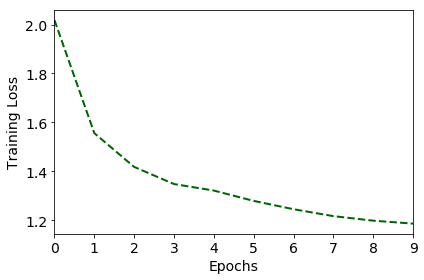

In [11]:
#Plot training loss as a function of training epochs

f = plt.figure(figsize=(6, 4))

l1 = plt.plot(np.arange(n_epochs), train_history.history['loss'], linewidth=2, color='darkgreen', linestyle='--')

plt.xlim(0, n_epochs - 1)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.xlabel("Epochs", fontsize=14)
plt.ylabel("Training Loss", fontsize=14)

plt.tight_layout()
plt.show()


Target iso = 1.0


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


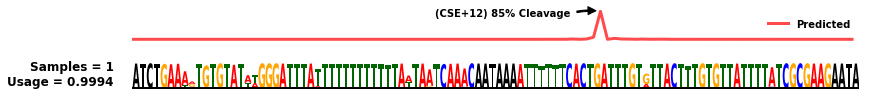

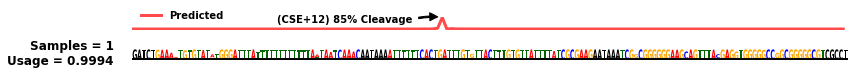

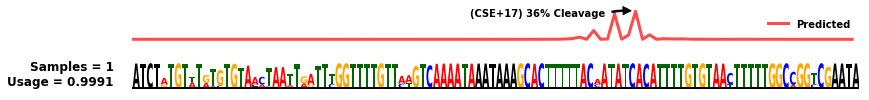

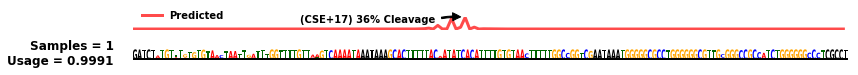

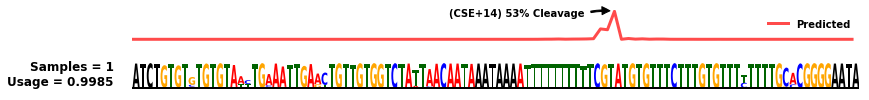

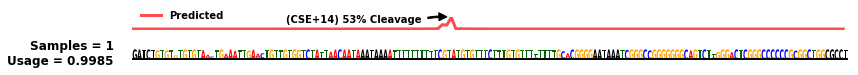

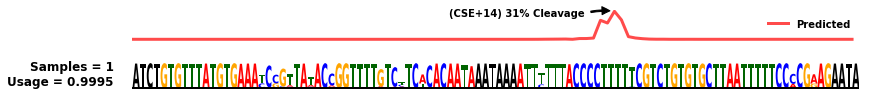

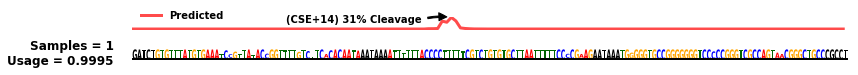

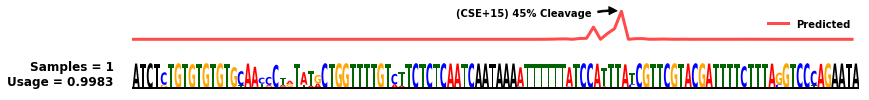

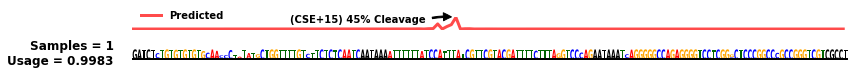

In [12]:
#Load GENESIS models and predict sample sequences

model_names = [
    'genesis_target_isoform_10_gan_simple_gen_resnet_4_resblocks_disc_conv_max_pool_hl_wgan_multisample_instancenorm_normal_singlesample_descent_simple_marginsim_05',
]

sequence_templates = [
    'TCCCTACACGACGCTCTTCCGATCTNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNAATAAANNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNAATAAANNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNCGCCTAACCCTAAGCAGATTCTTCATGCAATTG'
]

library_contexts = [
    'simple'
]

target_isos = [
    1.0
]

class_i = 0

print("Target iso = " + str(target_isos[class_i]))

save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = model_names[class_i] + '_predictor.h5'
model_path = os.path.join(save_dir, model_name)

predictor = load_model(model_path, custom_objects={'st_sampled_softmax': st_sampled_softmax, 'st_hardmax_softmax': st_hardmax_softmax, 'InstanceNormalization': InstanceNormalization})#, '<lambda>': lambda y_true, y_pred: y_pred

n = 32

sequence_class = np.array([0] * n).reshape(-1, 1) #np.random.uniform(-6, 6, (n, 1)) #

noise_1 = np.random.uniform(-1, 1, (n, 100))
noise_2 = np.random.uniform(-1, 1, (n, 100))

pred_outputs = predictor.predict([sequence_class, noise_1, noise_2], batch_size=32)

_, _, _, optimized_pwm, _, _, _, _, _, gan_seeds, _, iso_pred, cut_pred, _, _ = pred_outputs

#Plot one PWM sequence logo per optimized objective (Experiment 'Punish A-runs')

for pwm_index in range(5) :

    sequence_template = sequence_templates[class_i]

    pwm = np.expand_dims(optimized_pwm[pwm_index, :, :, 0], axis=0)
    cut = np.expand_dims(cut_pred[pwm_index, 0, :], axis=0)
    iso = np.expand_dims(np.sum(cut[:, 80: 115], axis=-1), axis=-1)

    plot_seqprop_logo(pwm, iso, cut, annotate_peaks='max', sequence_template=sequence_template, figsize=(12, 1.5), width_ratios=[1, 8], logo_height=0.8, usage_unit='fraction', plot_start=70-49, plot_end=76+49, save_figs=False, fig_name='target_isoform_genesis_simple_' + str(target_isos[class_i]).replace(".", "") + "_pwm_index_" + str(pwm_index), fig_dpi=150)

    plot_seqprop_logo(pwm, iso, cut, annotate_peaks='max', sequence_template=sequence_template, figsize=(12, 1), width_ratios=[1, 7], logo_height=0.8, usage_unit='fraction', plot_start=20, plot_end=177, save_figs=False, fig_name='target_isoform_genesis_simple_' + str(target_isos[class_i]).replace(".", "") + "_pwm_index_" + str(pwm_index), fig_dpi=150)


In [13]:
#Load GAN generator

aparent = load_model(saved_predictor_model_path)

gan_generator = load_model(saved_gan_path, custom_objects={'st_sampled_softmax': st_sampled_softmax, 'st_hardmax_softmax': st_hardmax_softmax, '<lambda>': lambda y_true, y_pred: y_pred, 'InstanceNormalization': InstanceNormalization})

sequence_templates_gan = [
    'TCCCTACACGACGCTCTTCCGATCTNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNCGCCTAACCCTAAGCAGATTCTTCATGCAATTG'
]
initialize_sequence_templates(gan_generator, sequence_templates_gan)


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


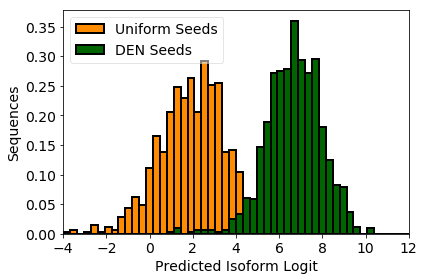

In [16]:

n = int(1000 / 32) * 32 + 32

fake_libs = np.zeros((n, 13))
fake_libs[:, 5] = 1.
fake_dpas = np.ones((n, 1))

#Generate non-conditioned sequences from GAN
gan_classes = np.zeros((n, 1), dtype=np.int)
gan_seeds = np.random.normal(loc=0., scale=1., size=(n, 100))

_, _, gan_sequences = gan_generator.predict([gan_classes, gan_seeds], batch_size=32)

gan_isoform_preds = np.sum(aparent.predict([np.moveaxis(gan_sequences, 1, -1), fake_libs, fake_dpas], batch_size=32)[1][:, 80: 115], axis=1)
gan_isoform_logits = np.log(gan_isoform_preds / (1. - gan_isoform_preds))

#Generate DEN-conditioned sequences from GAN
sequence_classes = np.zeros((n, 1), dtype=np.int)
noise_1 = np.random.uniform(low=-1., high=1., size=(n, 100))
noise_2 = np.random.uniform(low=-1., high=1., size=(n, 100))

den_seeds = predictor.predict([sequence_classes, noise_1, noise_2], batch_size=32)[9]

_, _, den_sequences = gan_generator.predict([gan_classes, den_seeds], batch_size=32)

den_isoform_preds = np.sum(aparent.predict([np.moveaxis(den_sequences, 1, -1), fake_libs, fake_dpas], batch_size=32)[1][:, 80: 115], axis=1)
den_isoform_logits = np.log(den_isoform_preds / (1. - den_isoform_preds))

#Calculate histogram statistics
logit_range = [-4, 12]

gan_logit_hist, bin_edges = np.histogram(gan_isoform_logits, bins=50, range=logit_range, density=True)
den_logit_hist, _ = np.histogram(den_isoform_logits, bins=50, range=logit_range, density=True)

f = plt.figure(figsize=(6, 4))

bar_width = np.abs(bin_edges[1] - bin_edges[0])

plt.bar(bin_edges[1:] - bar_width / 2., gan_logit_hist, width=bar_width, color='darkorange', edgecolor='black', linewidth=2, label='Uniform Seeds')
plt.bar(bin_edges[1:] - bar_width / 2., den_logit_hist, width=bar_width, color='darkgreen', edgecolor='black', linewidth=2, label='DEN Seeds')

plt.xlim(logit_range[0], logit_range[1])

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Predicted Isoform Logit", fontsize=14)
plt.ylabel("Sequences", fontsize=14)
plt.legend(fontsize=14, framealpha=0.5)

plt.tight_layout()
plt.show()


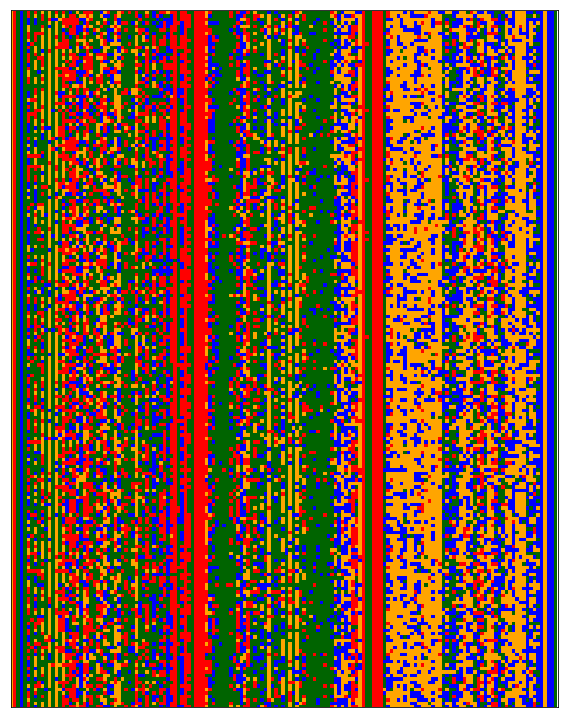

In [17]:
#Plot diversity grid

flat_sequences = np.zeros((n, 205))
for i in range(n) :
    for j in range(205) :
        max_nt_ix = np.argmax(den_sequences[i, 0, j, :])
        flat_sequences[i, j] = max_nt_ix + 1

flat_sequences = flat_sequences[:200, 20: 177]

cmap = colors.ListedColormap(['red', 'blue', 'orange', 'darkgreen'])
bounds=[0, 1, 2, 3, 4, 5]
norm = colors.BoundaryNorm(bounds, cmap.N)

f = plt.figure(figsize=(8, 12))

plt.imshow(flat_sequences[:200, :], aspect='equal', interpolation='nearest', origin='lower', cmap=cmap, norm=norm)

plt.xticks([], [])
plt.yticks([], [])

plt.xlim(0, 177 - 20)
plt.ylim(0, 200)

plt.tight_layout()
plt.show()
